In [35]:
using Pkg
using Revise

Pkg.activate("..")

# Pkg.update("FoodWebs")

using CairoMakie
using NetworkLayout
using GraphMakie, Graphs, MetaGraphs
using ColorSchemes

using FoodWebs
using LinearAlgebra
using StatsBase, Polynomials
using JLD2

fw = FoodWebs

  Activating project at `~/Projects/Working/HIFMB/TempRanges`


FoodWebs

# Introduction

In this notebook I will outline the simulation steps looking at the effects of shifts in species ranges with climate change. First I will describe the simulation procedure and then show some results. 

# Methods

Simulations are done as follows:

1. Generate a global pool of species with traits for body size $n$ and a thermal preference $0 < T_{pk} < 1$
2. Assemble $M$ stable communties using the niche model to generate their structure and the generalised modeling approach to ensure the proportion of stable webs (psw) is above some threshold. Each community has a temperature value $T$ and species are sampled so they are within some range of their respecitve preaks $T_{\text{range}}$.
3. Disperse species between communties according to one of two methods:
    1.  __Weighted__: Species disperse with a probability proportional to their body size $p_{d,i}(d) \propto n_i$. The communtiy to disperse to is sampled by weighting all communties with $e^{-2\lambda_i T_{\text{diff}}}$ where $T_{\text{diff}}$ is the difference in temperature between the two communties and $\lambda_i = (1 - n)^{0.75}$ is determined by body size. 
    2. __Random__: Species are selected randomly and disperse to all other communtities with uniform probability.

In [7]:
#1) GENERATE SPECIES POOL
N_pool = 100000
sp_vec = [fw.species(0.1) for i = 1:N_pool];

In [22]:
#2) ASSEMBLE COMMUNITIES
#set temperatures
N_T = 20
t_vec = range(0,1,length = N_T)

function generate_mc(sp_vec; verbose = false, vk = 100)
    #generate metacommunty
    mc = fw.stable_metacommunity(sp_vec, 20, t_vec, T_range = 0.1, R = 43.0,
             psw_threshold = 0.9, max_draws = 2000, verbose = verbose, vk = vk)

    mc_prob = deepcopy(mc)
    mc_random = deepcopy(mc)

    fw.check_metacommunity(mc);
    
    return mc_prob,mc_random
end

get_M(com) = (com.R .^ [s.n for s = com.sp])

get_M (generic function with 1 method)

In [23]:
mc = generate_mc(sp_vec, verbose = true, vk = 100)

draw:0 psw: [0.35, 0.1, 0.1, 0.58, 0.9, 0.23, 0.25, 0.27, 0.43, 0.05, 0.3, 0.52, 0.21, 0.31, 0.12, 0.07, 0.01, 0.03, 0.05, 0.04]
draw:100 psw: [0.3, 0.27, 0.48, 0.16, 0.9, 0.3, 0.14, 0.25, 0.26, 0.65, 0.92, 0.43, 0.01, 0.97, 0.1, 0.92, 0.23, 0.01, 0.31, 0.93]
draw:200 psw: [0.07, 0.04, 0.07, 0.03, 0.9, 0.91, 1.0, 0.04, 0.93, 0.02, 0.92, 0.03, 0.4, 0.97, 0.93, 0.92, 0.9, 0.03, 0.12, 0.93]
draw:300 psw: [0.29, 0.95, 0.11, 0.16, 0.9, 0.91, 1.0, 0.9, 0.93, 0.05, 0.92, 0.42, 0.45, 0.97, 0.93, 0.92, 0.9, 0.62, 0.97, 0.93]
draw:400 psw: [0.93, 0.95, 0.07, 0.01, 0.9, 0.91, 1.0, 0.9, 0.93, 0.13, 0.92, 0.2, 0.06, 0.97, 0.93, 0.92, 0.9, 0.24, 0.97, 0.93]
draw:500 psw: [0.93, 0.95, 0.08, 0.99, 0.9, 0.91, 1.0, 0.9, 0.93, 0.2, 0.92, 0.42, 0.93, 0.97, 0.93, 0.92, 0.9, 0.92, 0.97, 0.93]
draw:600 psw: [0.93, 0.95, 0.9, 0.99, 0.9, 0.91, 1.0, 0.9, 0.93, 0.15, 0.92, 0.92, 0.93, 0.97, 0.93, 0.92, 0.9, 0.92, 0.97, 0.93]


(MetaCommunity M:20 Sp: 400, MetaCommunity M:20 Sp: 400)

In [33]:
# #3) DISPERSAL
# # FoodWebs.K_dispersals!(mc1,10)
# N_dispersal = 2
# N_rep = 100
# N_trials = 10

# res = zeros(N_T, N_dispersal,N_rep,2,N_trials)
# params = Array{fw.GeneralisedParameters, 5}(undef, N_T, N_dispersal,N_rep,2,N_trials)
# bodysize = Array{Vector{Float64},4}(undef, N_T, N_dispersal,N_rep,2)

# Threads.@threads for r = 1:N_rep
#     mc_prob,mc_random = generate_mc(sp_vec)
    
#     for d = 1:N_dispersal
#         #probabablistic
#         for (i,c) = enumerate(mc_prob.coms)
#             #itterate for given web structure
#             for trial = 1:N_trials
#                 p = fw.generalised_parameters(c)
#                 J = similar(p.A)
#                 fw.generalised_jacobian!(J,p)
#                 res[i,d,r,1,trial] = fw.max_real_eigval(J) 
#                 params[i,d,r,1,trial] = deepcopy(p)
#             end
#         end
        
#         #random
#         for (i,c) = enumerate(mc_random.coms)
#             #itterate for given web structure
#             for trial = 1:N_trials
#                 p = fw.generalised_parameters(c)
#                 J = similar(p.A)
#                 fw.generalised_jacobian!(J,p)
#                 res[i,d,r,2,trial] = fw.max_real_eigval(J) 
#                 params[i,d,r,2,trial] = deepcopy(p)
#             end
#         end
        
#         bodysize[:,d,r,1] .= get_M.(mc_prob.coms)
#         bodysize[:,d,r,2] .= get_M.(mc_random.coms)


#         fw.multiple_dispersal!(mc_prob, p_dispersal = :p, d_dispersal = :p)
#         fw.multiple_dispersal!(mc_random, p_dispersal = :r, d_dispersal = :r)

#         if d % 100 == 0
#             print(i)
#         end
#     end
# end

# # save("simulations.jld2", Dict("res" => res, "params" => params, "bodysize" => bodysize))

In [92]:
r = load("../Data/simulations.jld2")


Dict{String, Any} with 3 entries:
  "res"      => [-0.191082 -0.123809; 0.117195 -0.839018; … ; -0.0180487 0.3093…
  "params"   => [GeneralisedParameters(20, [0.936569, 0.979253, 0.857588, 0.955…
  "bodysize" => [[33.8732, 39.7721, 25.1676, 36.4162, 4.22435, 20.0496, 1.17459…

In [98]:
N_T = size(r["res"])[1]

50

# Results

Here we have the results from the simulations. Across the communties we see a clear pattern of stability in the allometric (i.e. constrained) and the random dispersal. 

The allometric generally shows reduced stability at higher lattitudes presumably because of the influx more species.

In [93]:
psw = sum(r["res"] .< 0, dims = 5)[:,:,:,:,1] ./ 20

50×2×100×2 Array{Float64, 4}:
[:, :, 1, 1] =
 0.85  0.8
 0.65  1.0
 0.85  1.0
 0.85  1.0
 0.8   1.0
 0.9   1.0
 0.8   1.0
 0.95  1.0
 0.95  1.0
 0.9   1.0
 1.0   0.95
 0.85  1.0
 0.8   1.0
 ⋮     
 0.9   0.6
 0.85  0.85
 0.9   0.05
 0.95  0.6
 0.7   0.75
 0.8   0.4
 0.8   0.1
 1.0   0.8
 0.8   0.95
 0.7   0.75
 0.8   0.2
 0.95  0.0

[:, :, 2, 1] =
 0.9   0.55
 0.85  1.0
 0.8   1.0
 0.8   1.0
 0.85  1.0
 0.9   0.75
 1.0   0.95
 0.65  1.0
 0.65  1.0
 0.9   0.95
 0.75  1.0
 0.9   0.95
 0.8   1.0
 ⋮     
 0.75  0.75
 0.65  0.05
 0.85  0.95
 1.0   0.05
 0.9   1.0
 0.85  0.85
 0.9   0.2
 0.9   1.0
 0.85  0.5
 1.0   0.2
 0.85  0.7
 0.75  0.0

[:, :, 3, 1] =
 0.65  0.25
 0.9   1.0
 0.9   1.0
 0.8   1.0
 1.0   1.0
 0.85  1.0
 0.85  1.0
 0.7   1.0
 0.75  1.0
 1.0   1.0
 0.6   1.0
 0.75  1.0
 0.8   1.0
 ⋮     
 0.9   0.35
 0.9   0.65
 0.65  0.4
 0.9   0.65
 0.85  0.75
 0.85  0.65
 0.9   0.0
 0.95  0.75
 0.9   0.9
 0.8   0.55
 0.9   0.95
 0.95  0.0

;;; … 

[:, :, 98, 1] =
 0.9   0.45
 0.8   1.0
 

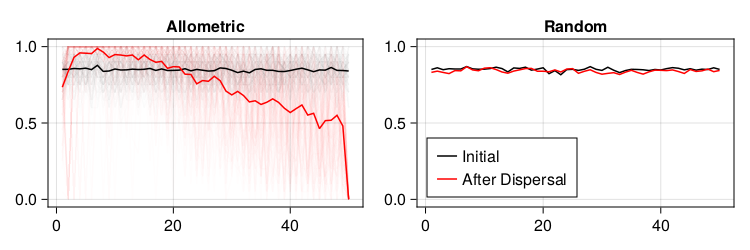

In [113]:
f = Figure(resolution=(750,250))
ax1 = Axis(f[1,1], title = "Allometric")


for r = 1:N_rep
        lines!(ax1, 1:N_T, psw[:,1,r,1], color = ("black", 0.01))
        lines!(ax1, 1:N_T, psw[:,2,r,1], color = ("red", 0.01))
end

lines!(ax1, 1:N_T, mean(psw,dims=3)[:,1,1,1], color = "black")
lines!(ax1, 1:N_T, mean(psw,dims=3)[:,2,1,1], color = "red")


ax2 = Axis(f[1,2], title = "Random")

for r = 1:N_rep
        lines!(ax2, 1:N_T, psw[:,1,r,2], color = ("black", 0.001))
        lines!(ax2, 1:N_T, psw[:,2,r,2], color = ("red", 0.001))
end

lines!(ax2, 1:N_T, mean(psw,dims=3)[:,1,1,2], color = "black", label = "Initial")
lines!(ax2, 1:N_T, mean(psw,dims=3)[:,2,1,2], color = "red", label = "After Dispersal")

axislegend(ax2,position = :lb)

linkyaxes!(ax1,ax2)


f

Zooming in on just the average stability the pattern is clearer

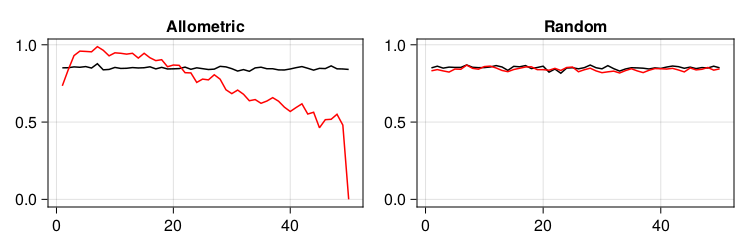

In [100]:
# f = Figure(resolution=(750,250))
# ax1 = Axis(f[1,1], title = "Allometric")

# T_range = 1:N_T

# lines!(ax1, T_range, mean(psw,dims=3)[T_range,1,1,1], color = "black")
# lines!(ax1, T_range, mean(psw,dims=3)[T_range,2,1,1], color = "red")

# ax2 = Axis(f[1,2], title = "Random")

# lines!(ax2, T_range, mean(psw,dims=3)[T_range,1,1,2], color = "black")
# lines!(ax2, T_range, mean(psw,dims=3)[T_range,2,1,2], color = "red")

# linkyaxes!(ax1,ax2)

# f

# Why?

So why do we see this consistent pattern in stability? One way to think about it is to look at bodysize distributions across the communities. Whilst it is constant before shuffling the non-random allometric dispersal results in a consistent shift in bodysize distributions. 

In [101]:
#1-D
nanmean(x) = mean(filter(x -> !isnan(x), x))
#n-D
nanmean(x, dims) = mapslices(nanmean, x, dims = dims)

nanmean (generic function with 2 methods)

In [102]:
maximum2(x) = length(x) > 0 ? maximum(x) : NaN
minimum2(x) = length(x) > 0 ? minimum(x) : NaN


minimum2 (generic function with 1 method)

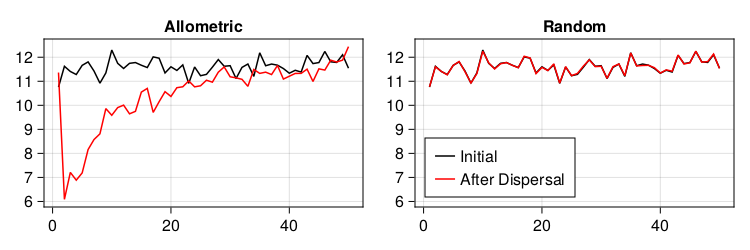

In [116]:
bs_mean = mean.(r["bodysize"])

f = Figure(resolution=(750,250))
ax1 = Axis(f[1,1], title = "Allometric")


# for r = 1:N_rep
#         lines!(ax1, 1:N_T, bs_mean[:,1,r,1], color = ("black", 0.01))
#         lines!(ax1, 1:N_T, bs_mean[:,2,r,1], color = ("red", 0.01))
# end

lines!(ax1, 1:N_T, nanmean(bs_mean,3)[:,1,1,1], color = "black")
lines!(ax1, 1:N_T, nanmean(bs_mean,3)[:,2,1,1], color = "red")


ax2 = Axis(f[1,2], title = "Random")

# for r = 1:N_rep
#         lines!(ax2, 1:N_T, bs_mean[:,1,r,2], color = ("black", 0.01))
#         lines!(ax2, 1:N_T, bs_mean[:,2,r,2], color = ("red", 0.01))
# end

lines!(ax2, 1:N_T, nanmean(bs_mean,3)[:,1,1,2], color = "black", label = "Initial")
lines!(ax2, 1:N_T, nanmean(bs_mean,3)[:,2,1,2], color = "red", label = "After Dispersal")

axislegend(ax2, position = :lb)

linkyaxes!(ax1,ax2)

f

Although messy we can see there is a tendency for the communties at lower lattitudes to loose the larger species whist those at the top gain them.

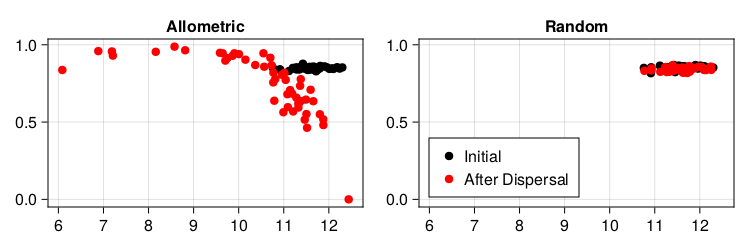

In [117]:
f = Figure(resolution=(750,250))

ax1 = Axis(f[1,1], title = "Allometric")
plot!(ax1, nanmean(bs_mean,3)[:,1,1,1], mean(psw,dims=3)[:,1,1,1], color = "black")
plot!(ax1, nanmean(bs_mean,3)[:,2,1,1], mean(psw,dims=3)[:,2,1,1],  color = "red")

ax2 = Axis(f[1,2], title = "Random")
plot!(ax2, nanmean(bs_mean,3)[:,1,1,2], mean(psw,dims=3)[:,1,1,2],  color = "black", label = "Initial")
plot!(ax2, nanmean(bs_mean,3)[:,2,1,2], mean(psw,dims=3)[:,2,1,2],  color = "red", label = "After Dispersal")

axislegend(ax2, position = :lb)

linkaxes!(ax1,ax2)

f

Plotting this against the stability measure we see that the systems that become more unstable are those that tend to have larger average bodysize. 

## Determinants of stability

Using the correlations can we work out what factors tend to drive stability?

In [125]:
p = r["params"][1]

sum(p.A, dims = 1) .+ sum(p.)

1×20 Matrix{Float64}:
 0.0  0.0  0.0  0.0  2.0  0.0  1.0  0.0  …  3.0  2.0  0.0  1.0  4.0  2.0  4.0

20×2×100×2 Array{Float64, 4}:
[:, :, 1, 1] =
 1.0   0.95
 0.9   1.0
 0.9   1.0
 1.0   1.0
 0.95  0.95
 0.9   1.0
 0.9   0.85
 0.95  1.0
 0.9   1.0
 1.0   0.7
 1.0   0.65
 0.95  1.0
 0.9   0.7
 0.75  0.95
 0.8   1.0
 0.75  0.85
 0.95  0.8
 0.95  0.8
 0.9   1.0
 0.75  0.0

[:, :, 2, 1] =
 0.9   0.95
 1.0   1.0
 0.95  1.0
 1.0   0.85
 1.0   1.0
 1.0   1.0
 0.95  1.0
 0.85  0.95
 0.9   0.75
 0.9   0.95
 0.95  1.0
 0.9   0.4
 0.9   0.65
 1.0   0.55
 0.75  0.55
 0.95  0.5
 0.8   0.6
 0.9   0.25
 0.9   0.25
 0.9   0.0

[:, :, 3, 1] =
 0.85  0.85
 1.0   0.85
 0.8   1.0
 0.8   1.0
 0.95  1.0
 0.95  1.0
 0.95  1.0
 0.85  1.0
 0.9   0.7
 0.85  1.0
 1.0   0.85
 0.9   0.9
 0.8   0.75
 0.95  0.8
 1.0   0.3
 0.75  0.0
 0.85  0.65
 1.0   0.7
 0.85  0.9
 0.8   0.0

;;; … 

[:, :, 98, 1] =
 0.9   1.0
 0.85  1.0
 0.8   1.0
 0.95  0.8
 0.95  1.0
 0.85  1.0
 0.85  0.7
 0.85  1.0
 0.95  0.5
 0.95  0.9
 0.75  0.85
 0.95  0.9
 0.95  0.45
 0.95  0.9
 0.9   1.0
 1.0   0.65
 0.95  0.9
 1.0   0.15
 0.9   0.05
 1.

In [329]:
fit.coeffs[1] .+ fit.coeffs[2] .* range(-10,10,length = 100)


0.14490101350299575:-0.006403542384005441:-0.48904968251354286

# Foodweb Plotting

In [ ]:
function foodweb_layout(g)
    ny = 1 .- g.gprops[:n]
    nx = rand(length(g.gprops[:n]))
    return(Point.(zip(nx, ny)))
end

foodweb_layout (generic function with 1 method)

In [ ]:
#plotting
stable_coms = [communities[i,x[2]] for (i,x) = enumerate(stable_indx)]

#convert to graphs
g_vec = Vector{Any}(undef, N_temp)
for (i,sc) = enumerate(stable_coms)
    g = MetaDiGraph(SimpleDiGraph(sc.A))
    set_prop!(g, :n, [x.n for x = sc.sp])
    
    g_vec[i] = g
end

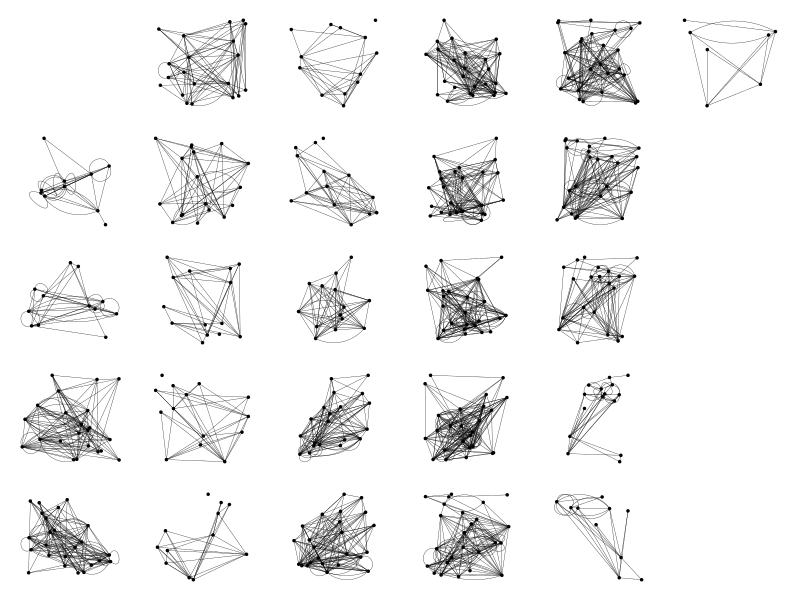

In [53]:
f = Figure()

ax = [Axis(f[i % 5,(i ÷ 5)]) for i = 1:N_temp]

[graphplot!(ax[i],g_vec[i], layout=foodweb_layout, edge_width = 0.3, arrow_size = 0.0, node_size = 5) for i = 1:N_temp]
hidedecorations!.(ax); hidespines!.(ax)
[ax[i].aspect = DataAspect() for i = 1:N_temp]

f

In [54]:
#calculate sp_occurance
result = Vector{Any}(undef, length(sp_vec))
id_sp = Dict{Base.UUID,Vector{Any}}()

for i = CartesianIndices(stable_coms)
    for s = communities[i].sp
        if s.id in keys(id_sp)
            push!(id_sp[s.id], i)
        else
            id_sp[s.id] = [i]
        end
    end
end
